In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
import torch.optim as optim


from Misc.Functions.DataProduction import dataProd

import warnings
warnings.filterwarnings('ignore')

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Data production and loading
run_list = [285490, 286498, 287987, 288543, 289413, 289733, 291970, 293528]
planes_list = ['UTaX', 'UTaU', 'UTbV', 'UTbX']

dataProduction = dataProd()
mix_ = dataProduction.multipleRun(*run_list)
mix = mix_.copy()
pedestalOnly = pd.DataFrame(index=np.arange(18) + 1)

for i, v in enumerate(run_list):
    for plane in planes_list:
        temp_ = mix[v].loc[(mix[v, 'Plane'] == plane)][['Side', 'Position', 'PedestalValue']]
        temp_['Stave'] = temp_['Side'] + temp_['Position'].astype(str)
        temp_.drop(['Side', 'Position'], axis=1, inplace=True)
        pedestalOnly[['Stave', f'Run{i + 1}_{plane}']] = temp_.groupby(['Stave']).agg('mean')['PedestalValue'].reset_index()

pedestalOnly_ = pedestalOnly.drop(['Stave'], axis=1).fillna(0)


# Extract and preprocess UTaX data
utax_ = pedestalOnly_[pedestalOnly_.filter(regex='UTaX').columns]
utax = utax_.values.flatten()
ts = pd.DataFrame(index=np.arange(len(utax)))
ts['utax'] = utax
ts = ts[ts['utax'] != 0]

# Fit and transform the data
ts['utax_scaled'] = scaler.fit_transform(ts[['utax']])

data = ts['utax_scaled'].values


In [2]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 15
num_epochs = 1000
# learning_rate = 0.001


np.random.seed(42)

data = ts['utax_scaled'].values

train_size = int(len(data) * 0.75)

train_data = data[:train_size]
test_data = data[train_size:]

train_data = np.tile(train_data, 5)


# Prepare the data
def create_sequences(data, input_len, output_len):
    xs, ys = [], []
    for i in range(len(data) - input_len - output_len + 1):
        x = data[i:i+input_len]
        y = data[i+input_len:i+input_len+output_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_len = 15
output_len = 15

x_train, y_train = create_sequences(train_data, input_len, output_len)
x_test, y_test = create_sequences(test_data, input_len, output_len)



# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)



x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1) 
y_test = torch.tensor(y_test, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Making predictions
model.eval()
with torch.no_grad():
    predictions = model(x_test)
    print(predictions[-1]) 


torch.save(model,f='./Misc/Models/LSTMModel.pt')

Epoch [100/1000], Loss: 0.0160
Epoch [200/1000], Loss: 0.0160
Epoch [300/1000], Loss: 0.0160
Epoch [400/1000], Loss: 0.0160
Epoch [500/1000], Loss: 0.0161
Epoch [600/1000], Loss: 0.0158
Epoch [700/1000], Loss: 0.0155
Epoch [800/1000], Loss: 0.0142
Epoch [900/1000], Loss: 0.0112
Epoch [1000/1000], Loss: 0.0067
tensor([0.3731, 0.2364, 0.2454, 0.3540, 0.4065, 0.4066, 0.3190, 0.3508, 0.3172,
        0.2380, 0.2911, 0.2972, 0.3282, 0.4000, 0.4611])


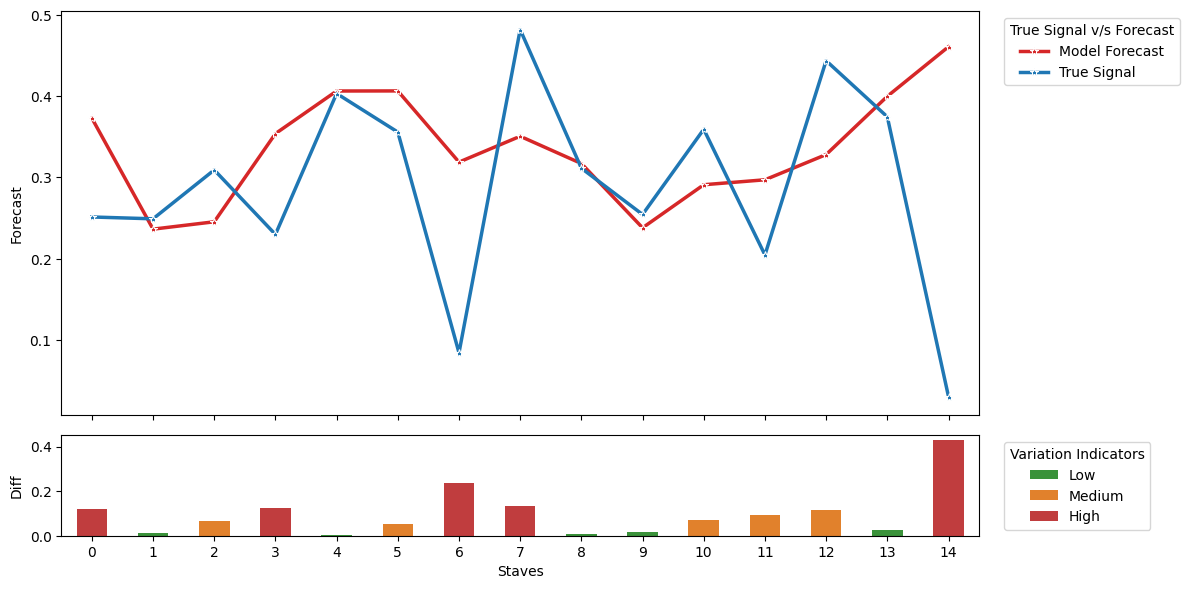

In [3]:
#Test Case
model=torch.load(f='Misc/Models/LSTMModel.pt')
model.eval()

with torch.no_grad():
    output = model(x_test)
    
custom_colors = {'Low': 'tab:green', 'Medium': 'tab:orange', 'High': 'tab:red'}

variations = pd.DataFrame(index=np.arange(15))
variations['TrueSignal'] = y_test[0].detach().numpy()
variations['Forecast'] = output[0].detach().numpy()

variations['Diff'] = np.abs(variations['TrueSignal'] - variations['Forecast'])
variations['Alert']=pd.qcut(variations['Diff'],q=3,labels=['Low','Medium','High'])

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,6),gridspec_kw={'height_ratios': [4, 1]},sharex=True)
sns.lineplot(variations['Forecast'],marker='*',label='Model Forecast',linewidth=2.5,color='tab:red',ax=ax1)
sns.lineplot(variations['TrueSignal'],marker='*',label='True Signal',linewidth=2.5,color='tab:blue',ax=ax1)


sns.barplot(data=variations, x=variations.index, y='Diff', hue='Alert',width=0.5,palette=custom_colors,ax=ax2)

ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='True Signal v/s Forecast')
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Variation Indicators')

plt.xlabel('Staves')
plt.tight_layout()
plt.show()




In [4]:
model=torch.load(f='Misc/Models/LSTMModel.pt')
model.eval()

def variation_plot(data,filename):
    with torch.no_grad():
        output = model(data.reshape(1,15,1))

    custom_colors = {'Low': 'tab:green', 'Medium': 'tab:orange', 'High': 'tab:red'}

    variations = pd.DataFrame(index=np.arange(15))
    variations['TrueSignal'] = data.detach().numpy()
    variations['Forecast'] = output[0].detach().numpy()


    variations['Abs. Difference'] = np.abs(variations['TrueSignal'] - variations['Forecast'])
    variations['Alert']=pd.cut(variations['Abs. Difference'],bins=[0, 0.25, 0.5,1],labels=['Low','Medium','High'])

    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,6),gridspec_kw={'height_ratios': [4, 1]},sharex=True)
    sns.lineplot(variations['Forecast'],marker='*',label='Model Forecast',linewidth=2.5,color='tab:red',ax=ax1)
    sns.lineplot(variations['TrueSignal'],marker='*',label='True Signal',linewidth=2.5,color='tab:blue',ax=ax1)
    

    sns.barplot(data=variations, x=variations.index, y='Abs. Difference', hue='Alert',width=0.5,palette=custom_colors,ax=ax2)

    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='True Signal v/s Forecast')
    ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Variation Indicators')

    ax1.set(ylim=(0, 1))
    ax1.set_ylabel('True Signal - Forecasted Signal')
    ax2.set(ylim=(0, 1))

    plt.xlabel('Staves')
    plt.tight_layout()
    

    plt.savefig(filename)

    print("Image Processed and Saved.!")
    # plt.show()



Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!
Image Processed and Saved.!


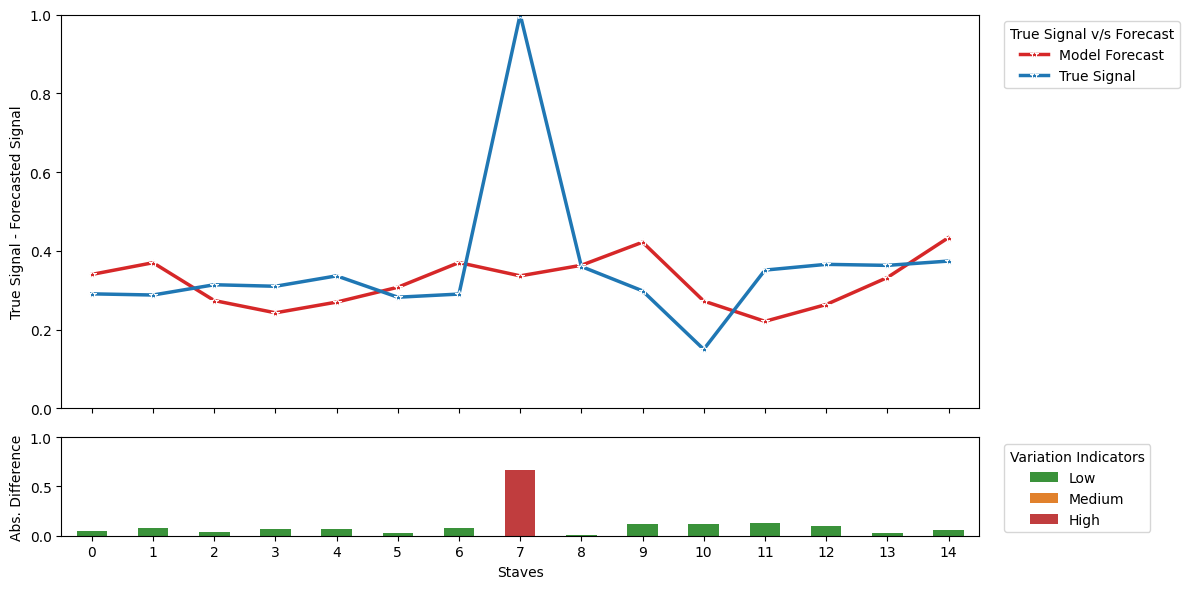

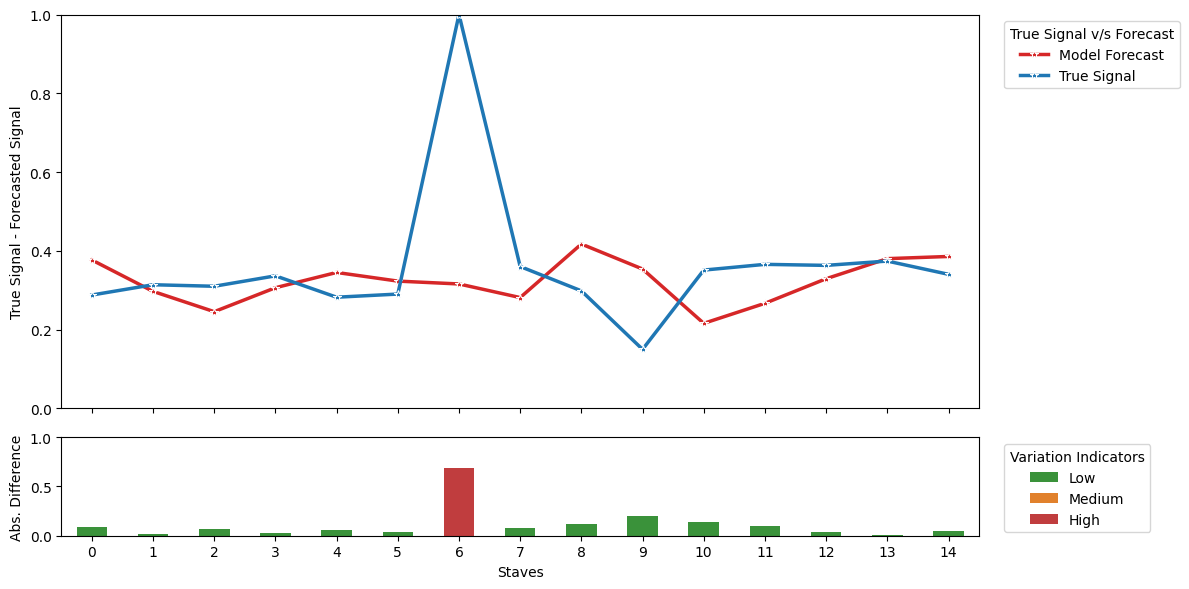

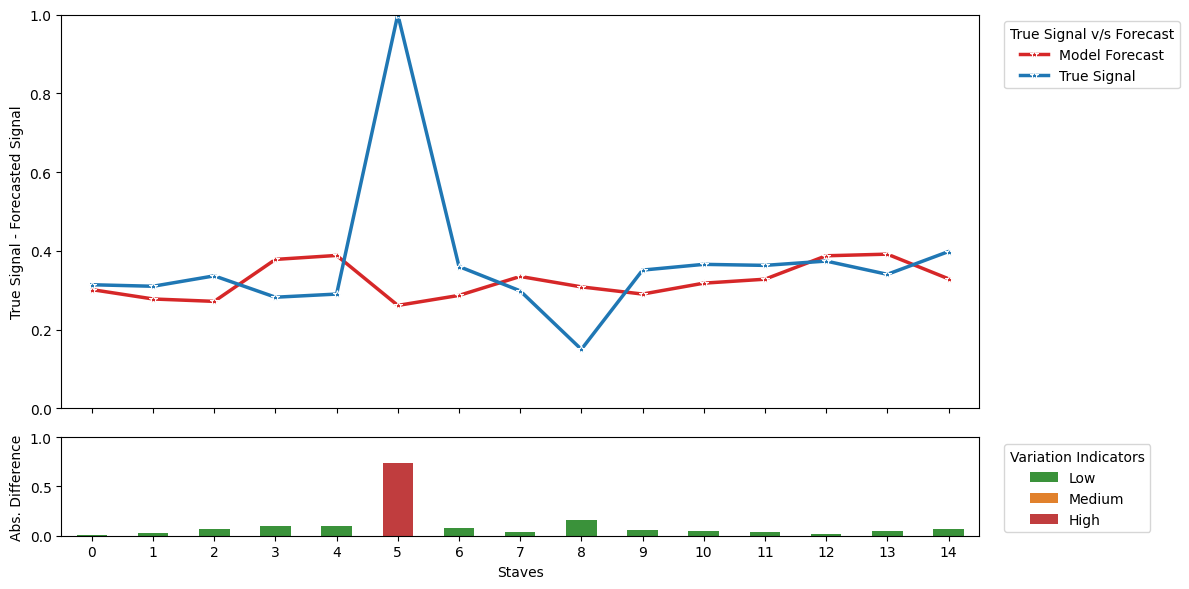

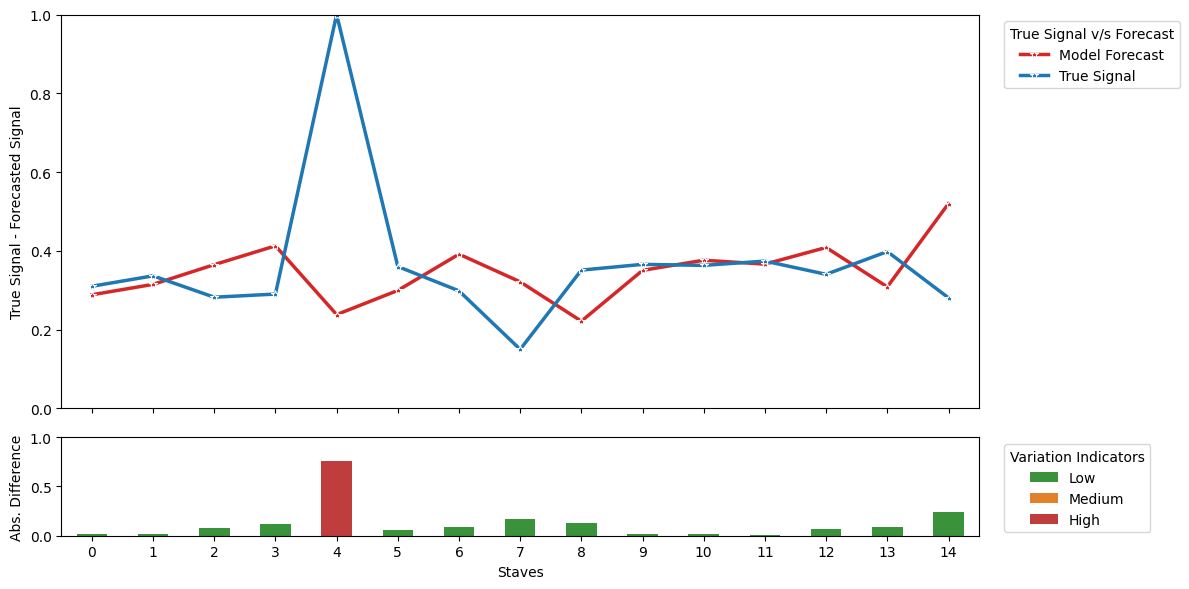

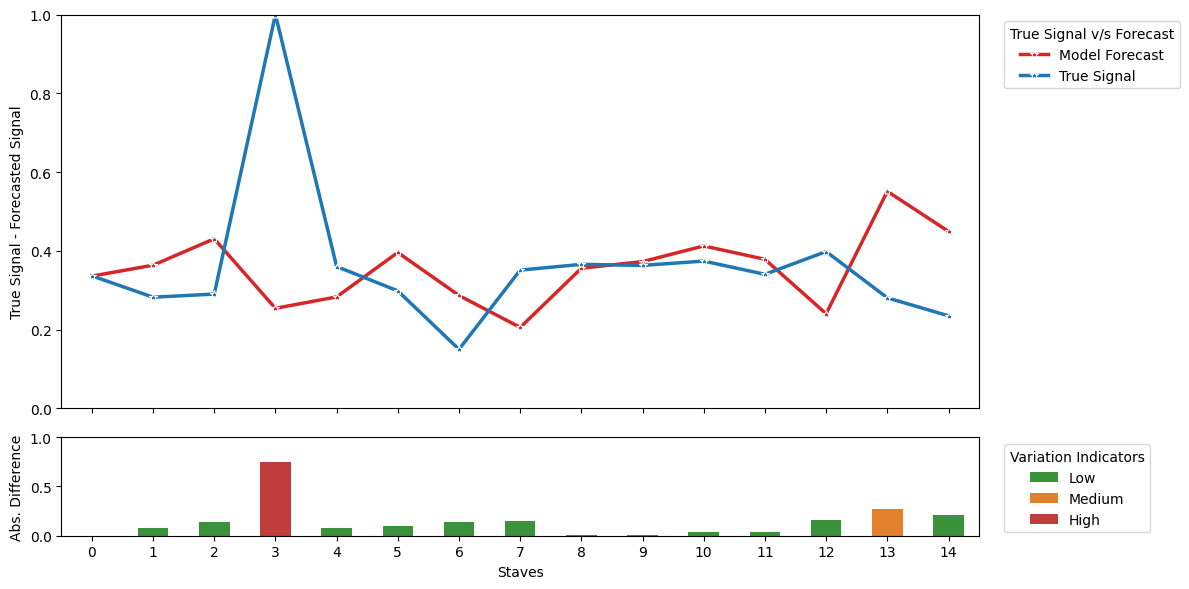

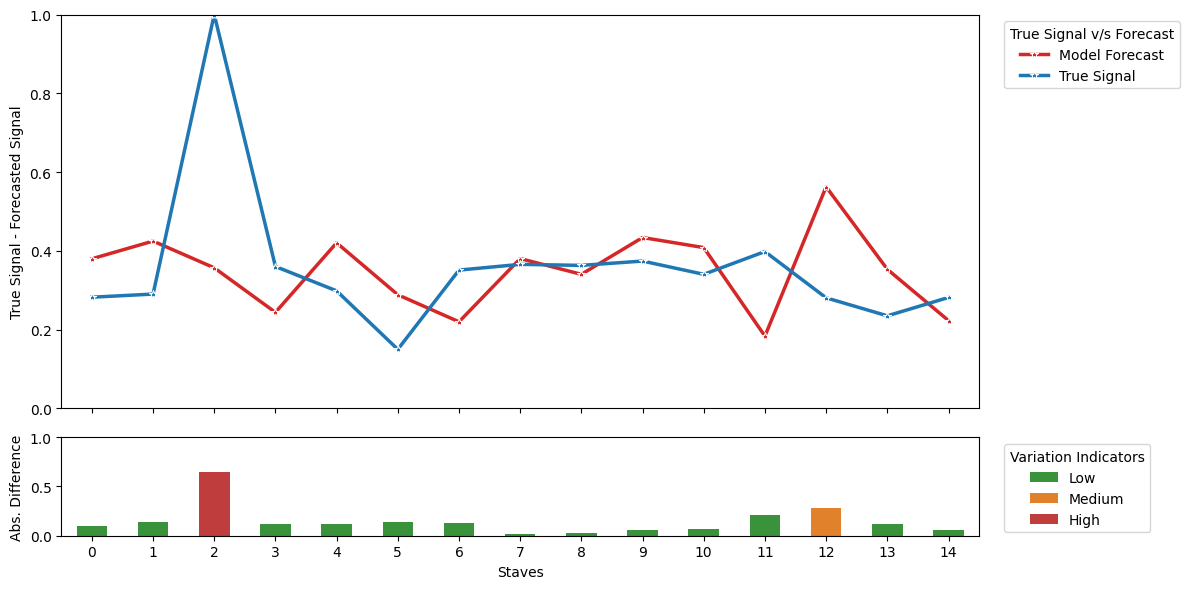

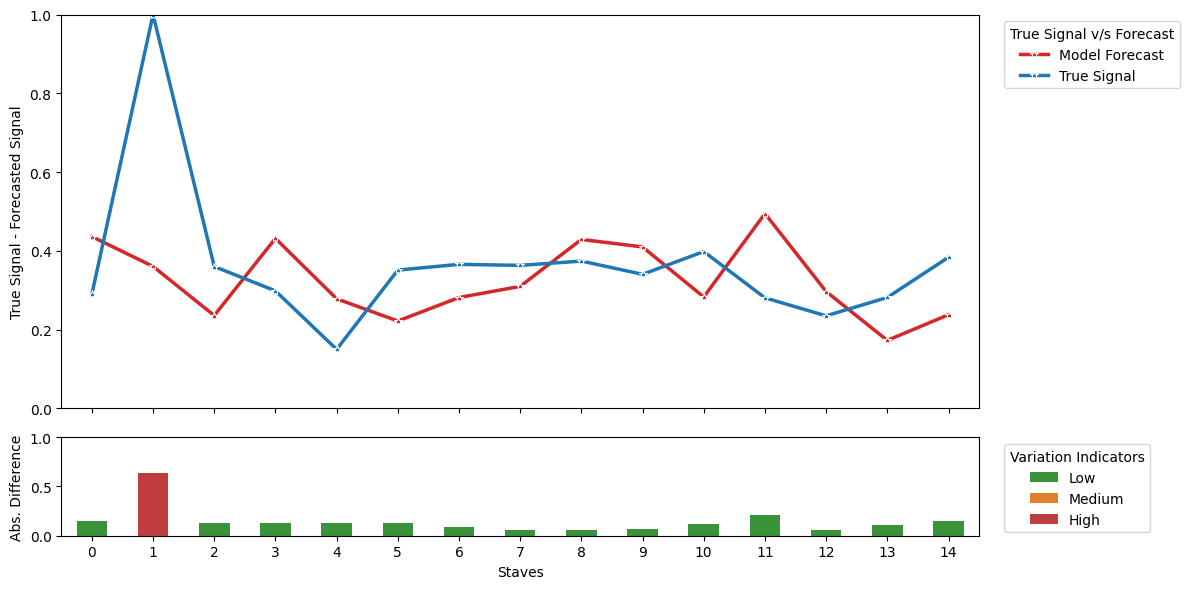

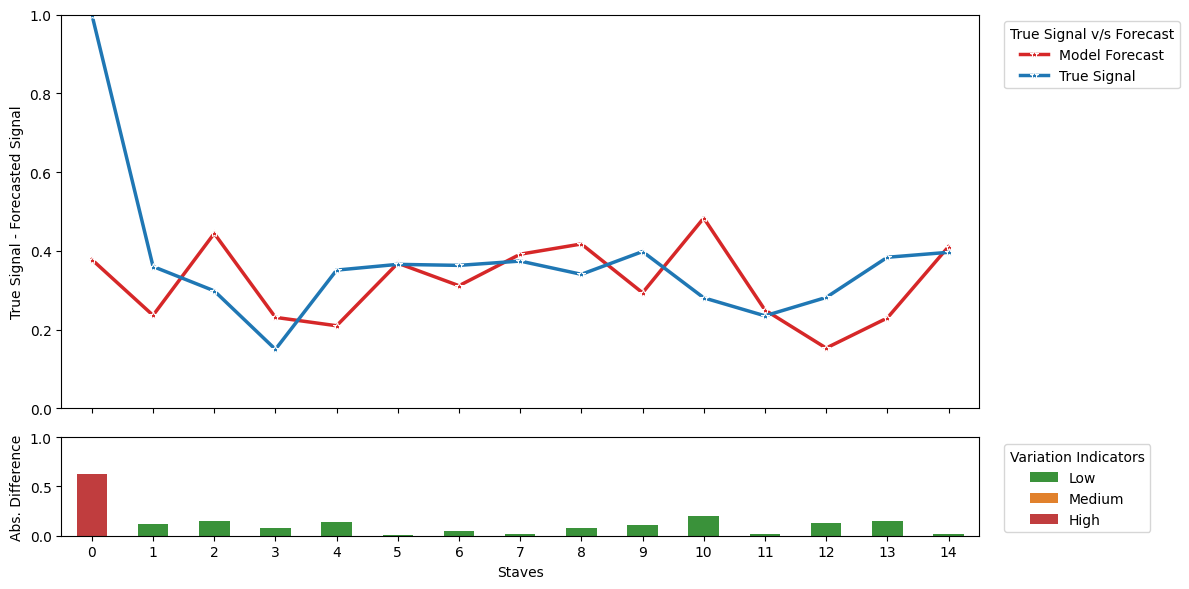

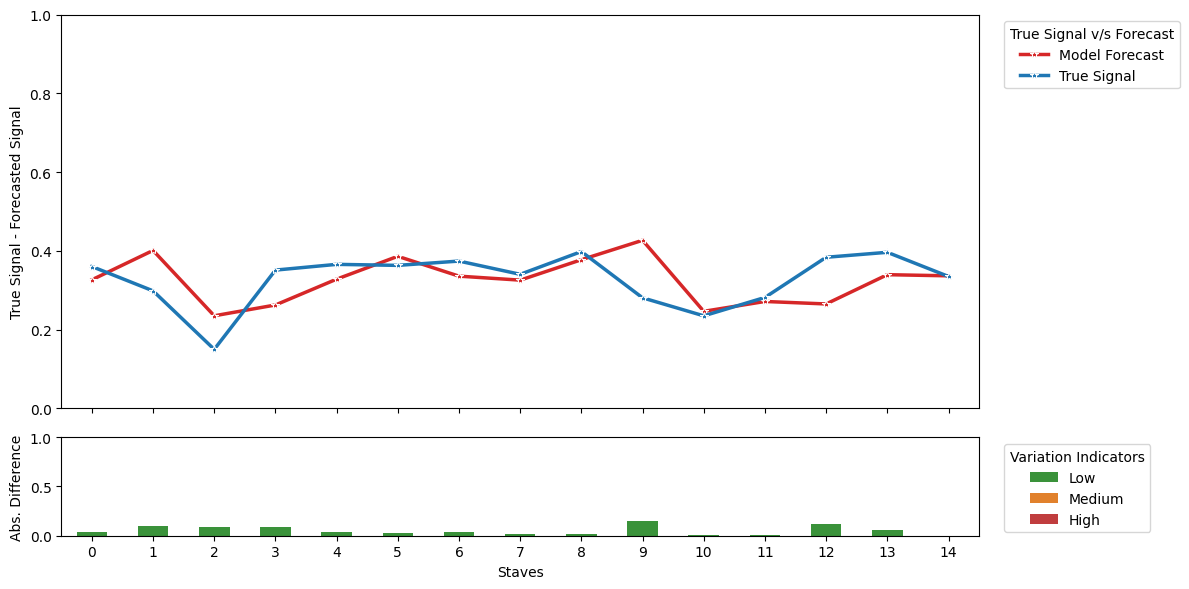

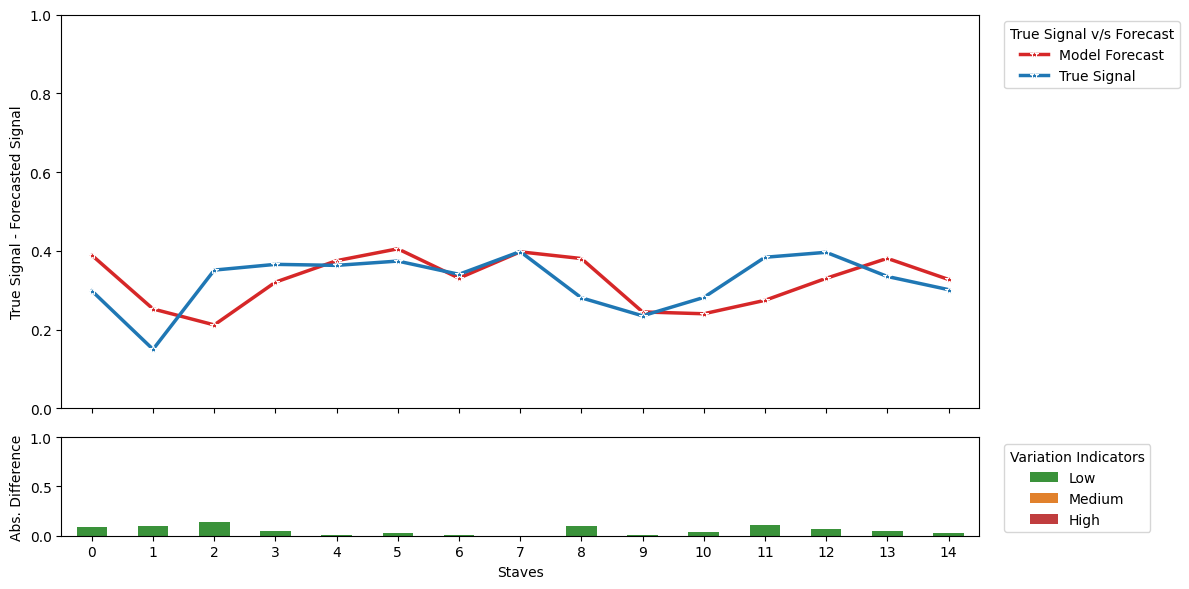

In [5]:
for i in range(10):
    # print(i)
    variation_plot(x_train[i],f'Misc/Plots/LSTM/{i}')